In [1]:
import tensorflow as tf
import numpy as np
from sklearn.decomposition import PCA
import tensorflow as tf

2023-05-24 11:53:10.833331: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-24 11:53:11.222425: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [10]:
background = np.load('./data/Ferguson_fire_background.npy')
obs = np.load('./data/Ferguson_fire_obs.npy')

background_1D = np.reshape(background,(5,256*256))
obs_1D = np.reshape(obs,(5,256*256))

In [11]:
from obs3_DA import DAwrapper
import time

start = time.time()
da = DAwrapper(background,obs,0.999999)
da.compress()
da.assimilate()
recon = np.reshape(da.reconstruct(da.predictions_assimilated),(5,256,256))

end = time.time() - start
print(end)

0.12558317184448242


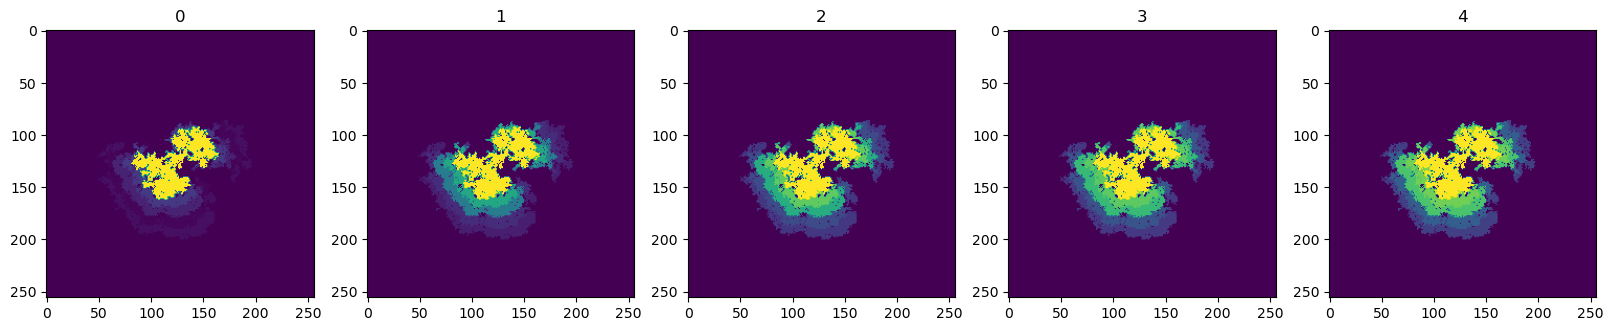

In [12]:
import matplotlib.pyplot as plt
def plot_img(data,ts):
  fig,axes = plt.subplots(1,5,figsize=[20,8])
  for i, ax in enumerate(axes.ravel()):
    im = ax.imshow(data[ts[i]])
    ax.set_title(str(ts[i]))
     
plot_img(recon,[x for x in range(5)])


In [13]:
from sklearn.metrics import mean_squared_error
mean_squared_error(np.reshape(obs,(5,256*256)),np.reshape(recon,(5,256*256)))

0.06298273298245786

Epoch 1/20
1/1 [==============================] - 2s 2s/step - loss: 0.0802
Epoch 2/20
1/1 [==============================] - 0s 152ms/step - loss: 0.0758
Epoch 3/20
1/1 [==============================] - 0s 155ms/step - loss: 0.0668
Epoch 4/20
1/1 [==============================] - 0s 156ms/step - loss: 0.0476
Epoch 5/20
1/1 [==============================] - 0s 154ms/step - loss: 0.0438
Epoch 6/20
1/1 [==============================] - 0s 152ms/step - loss: 0.0336
Epoch 7/20
1/1 [==============================] - 0s 153ms/step - loss: 0.0367
Epoch 8/20
1/1 [==============================] - 0s 158ms/step - loss: 0.0402
Epoch 9/20
1/1 [==============================] - 0s 214ms/step - loss: 0.0314
Epoch 10/20
1/1 [==============================] - 0s 148ms/step - loss: 0.0293
Epoch 11/20
1/1 [==============================] - 0s 166ms/step - loss: 0.0287
Epoch 12/20
1/1 [==============================] - 0s 166ms/step - loss: 0.0303
Epoch 13/20
1/1 [==============================] - 0

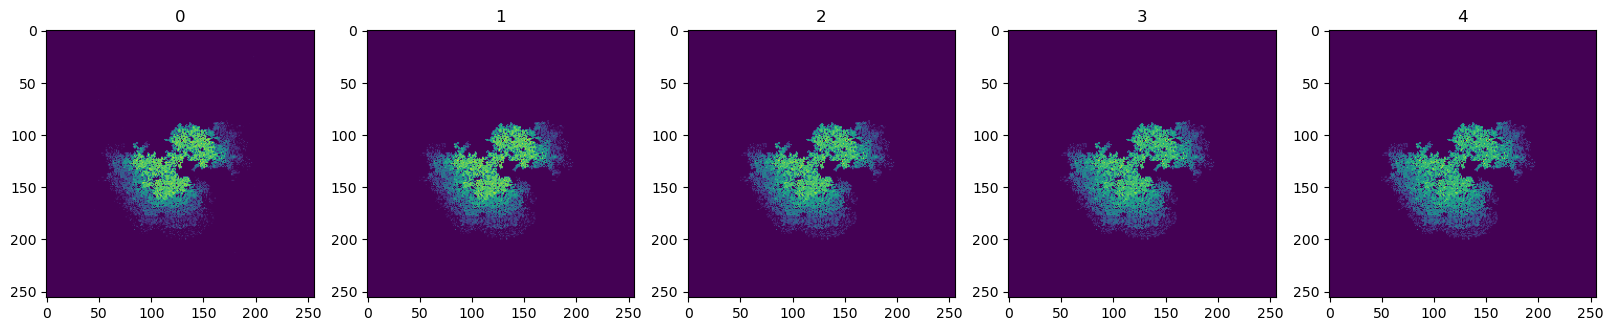

In [30]:
# Common imports
import numpy as np
import time
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, losses, Model
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
start = time.time()


class Autoencoder(Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),

      layers.Dense(100,activation='relu'),
      layers.Dropout(0.5), #dropout layer to prevent overfitting

      layers.Dense(latent_dim, activation='relu'),
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(100,activation='relu'),
      layers.Dense(256*256, activation='relu'),
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

latent_dim = 30
autoencoder = Autoencoder(latent_dim)
epochs = 20

autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())
fitted = autoencoder.fit(background_1D, background_1D,
                epochs=epochs,
                shuffle=True,)

from numpy.linalg import inv

background_comp = autoencoder.encoder.predict(background_1D)
obs_comp = autoencoder.encoder.predict(obs_1D)
def update_prediction(x, K, H, y):

    res = x + np.dot(K,(y - np.dot(H, x)))
    return res  

def KalmanGain(B, H, R):
    tempInv_1 = np.dot(H,np.dot(B,H.transpose()))
    tempInv_2 =  inv(R + tempInv_1)
    res = np.dot(B,np.dot(H.transpose(),tempInv_2))
    return res


I = np.identity(background_comp.shape[1])
R = I
H = I 
B = np.cov(background_comp.T) 
K = KalmanGain(B, H, R) 
updated_data_list = []
for i in range(len(background_comp)):
    updated_data = update_prediction(background_comp[i], K, H, obs_comp[i]) 
    updated_data_list.append(updated_data)
updated_data_array = np.array(updated_data_list)

recon_ae = autoencoder.decoder.predict(updated_data_array)

plot_img(np.reshape(recon_ae,(5,256,256)),[x for x in range(5)])


execution_time = time.time()-start

In [31]:
mean_squared_error(np.reshape(obs,(5,256*256)),recon_ae)

0.06821030124302539

In [32]:
execution_time

8.119894981384277

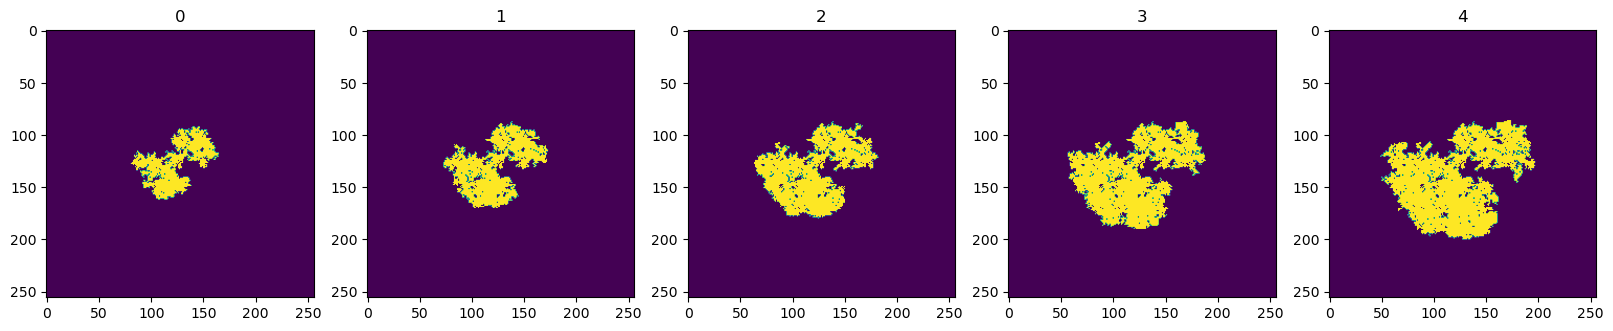

In [35]:
plot_img(background,[x for x in range(5)])

In [20]:
print ('Start PCA')
start = time.time ()
pca = PCA(0.95)
predicitons_compressed = pca.fit_transform(predictions)
test_compressed = pca.transform(obs)
test_reconstructed = pca.inverse_transform(test_compressed)
end = time.time()
print("PCA took {:.2f} seconds.".format(end - start))

Start PCA
PCA took 0.05 seconds.


In [22]:
predicitons_compressed

array([[-32.58907  , -14.890524 ,   8.506341 ,  -5.979518 ],
       [-22.33676  ,   2.1473029,  -9.859719 ,  12.603375 ],
       [ -2.6528547,  18.773458 ,  -6.5203376, -10.85108  ],
       [ 20.54158  ,   9.951693 ,  15.272858 ,   5.983348 ],
       [ 37.037113 , -15.981934 ,  -7.3992424,  -1.7561346]],
      dtype=float32)

In [25]:
from numpy.linalg import inv

def covariance_matrix(X):
    means = np.array([np.mean(X, axis = 1)]).transpose()
    dev_matrix = X - means
    res = np.dot(dev_matrix, dev_matrix.transpose())/(X.shape[1]-1)
    return res

def update_prediction(x, K, H, y):
    res = x + np.dot(K,(y - np.dot(H, x)))
    return res  

def KalmanGain(B, H, R):
    tempInv = inv(R + np.dot(H,np.dot(B,H.transpose())))
    res = np.dot(B,np.dot(H.transpose(),tempInv))
    return res

def mse(y_obs, y_pred):
    return np.square(np.subtract(y_obs,y_pred)).mean()

In [26]:
####this cell is only required because the dataset is too large
#we will select a few data points to run the assimilation with
#uncomment the next line if running with all data points
# nNodes = rows * columns * channels 

nNodes = 4 #select a few data points for the assimilation
# model_data = predicitons_compressed[:,:nNodes]
# sensors_data = test_compressed[:,:nNodes]

In [27]:
#nNodes = rows * columns * channels
# I = np.identity(10)
I = np.identity(nNodes)
R = np.cov(test_compressed.T) # or R =covariance_matrix(np.array(sensors_data).T) #Observation error covariance
H = I #Observation operator
B = np.cov(predicitons_compressed.T)  #or B = covariance_matrix(np.array(model_data).T) #Background error covariance

In [28]:
print('Start Assimilation')
start = time.time()

K = KalmanGain(B, H, R) 

updated_data_list = []
for i in range(len(predicitons_compressed)):
    updated_data = update_prediction(predicitons_compressed[i], K, H, test_compressed[i]) #compute only the analysis
    updated_data_list.append(updated_data)
updated_data_array = np.array(updated_data_list)

end = time.time()   

print('MSE before assimilation: ', mse(test_compressed, predicitons_compressed))
print('MSE after assimilation: ', mse(test_compressed, updated_data_array))
print(f'Time for assimilation: {end-start} seconds')


Start Assimilation
MSE before assimilation:  176.58449825350345
MSE after assimilation:  1.980630212921838
Time for assimilation: 0.0021812915802001953 seconds
